In [41]:
import numpy as np
import os
from google.colab import drive
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating Environment

In [42]:

class GridWorld:
    def __init__(self, height, width, start, end, bad_region_clusters, good_region_clusters, final_reward, sparsity):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_region_clusters = bad_region_clusters
        self.good_region_clusters = good_region_clusters
        # self.good_region_reward = good_region_reward
        # self.bad_region_reward = bad_region_reward
        self.final_reward = final_reward
        self.sparsity = sparsity

        self.state_rewards = self.generate_state_rewards()
        self.reset()

    def reset(self):
        self.agent_position = self.start


    def generate_state_rewards(self):
        state_rewards = {}
        for x in range(self.width):
            for y in range(self.height):
                state_reward = 0.0

                if (x, y) == self.start:
                    state_reward = 0.0
                elif (x, y) == self.end:
                    state_reward = self.final_reward
                else:
                    for cluster in self.good_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    for cluster in self.bad_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    if state_reward == 0.0:
                        state_reward = 0.5 if np.random.random() < self.sparsity else 0.0

                state_rewards[(x, y)] = state_reward

        return state_rewards


    def step(self, action):
        x, y = self.agent_position

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get((x, y), 0)

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        # Update agent position
        self.agent_position = (x, y)

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get(self.agent_position, 0)


        if self.agent_position in self.end:
            done = True
        else:
            done = False

        # Get the reward for the updated position and policy context
        updated_reward = self.state_rewards.get(self.agent_position, 0)

        # Check if the new position is the end state
        done = (self.agent_position == self.end)

        return self.agent_position, updated_reward, done



In [43]:
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), -0.5), ((1, 1), -0.5)]
good_cluster = []

# Create an instance of GridWorld
gridworld = GridWorld(
    height=5,
    width=5,
    start=(0, 0),
    end=(4, 4),
    bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],
    final_reward=10,
    sparsity=0.0
)

# Access the state_rewards dictionary
rewards = gridworld.state_rewards

# Print the rewards for each state
for state, reward in rewards.items():
    print(f"State: {state}, Reward: {reward}")

State: (0, 0), Reward: 0.0
State: (0, 1), Reward: 0.0
State: (0, 2), Reward: 0.0
State: (0, 3), Reward: 0.0
State: (0, 4), Reward: 0.0
State: (1, 0), Reward: 0.0
State: (1, 1), Reward: 0.0
State: (1, 2), Reward: 0.0
State: (1, 3), Reward: 0.0
State: (1, 4), Reward: 0.0
State: (2, 0), Reward: 0.0
State: (2, 1), Reward: 0.0
State: (2, 2), Reward: 0.0
State: (2, 3), Reward: -1.0
State: (2, 4), Reward: -1.0
State: (3, 0), Reward: 0.0
State: (3, 1), Reward: 0.0
State: (3, 2), Reward: 0.0
State: (3, 3), Reward: -1.0
State: (3, 4), Reward: 0.0
State: (4, 0), Reward: 0.0
State: (4, 1), Reward: 0.0
State: (4, 2), Reward: 0.0
State: (4, 3), Reward: 0.0
State: (4, 4), Reward: 10


In [44]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

# def behavior_policy(behav_policy):
#     action_probs = behav_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def evaluation_policy(eval_policy):
#     action_probs = eval_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def run_policy(policy):
    action_probs = policy
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))


def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

# Generating Policy data

In [45]:
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [46]:
def create_policy_set(env, policy_func, policy, num_episodes):
  # Create a list to store policies as trajectories
  policies = []

  # Run multiple episodes
  for episode in range(num_episodes):
      # Create a new Agent for each episode to generate a different policy

      agent = Agent(epsilon=0.0)

      # print(episode)
      # Run an episode
      env.reset()
      done = False
      trajectory = []  # Store the trajectory for the current episode
      cumulative_reward = 0.0  # Initialize cumulative reward
      while not done:
          state = env.agent_position  # Get the current state
          # print("State: ",state)
          action = agent.select_action(lambda: policy_func(policy))
          # print("Action: ",action)
          next_state, reward, done = env.step(action)
          # print("Next State: ", next_state)

          # Compute cumulative reward
          cumulative_reward += reward

         # Compute mean of the Manhattan distances to points in the good and bad region clusters
          # good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.good_region_clusters]
          # bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.bad_region_clusters]
          # good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) if cluster else None for cluster in env.good_region_clusters]
          # bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) if cluster else None for cluster in env.bad_region_clusters]
          good_region_distances = []
          if env.good_region_clusters:
              good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.good_region_clusters]

          bad_region_distances = []
          if env.bad_region_clusters:
              bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.bad_region_clusters]



          # Store the (state, action, reward, next_state) tuple in the trajectory
          trajectory.append((state, action, reward, next_state, cumulative_reward, good_region_distances, bad_region_distances))

      # Append the trajectory to the policies list
      policies.append(trajectory)

  return policies


In [47]:
# pi_b = create_policy_set(gridworld, run_policy, behav_policy, 200)

In [48]:
def calc_V_pi_e(evaluation_policies):
    all_timesteps = []
    gamma = 0.9
    for j in range(len(evaluation_policies)):
        Timestep_values = []
        for i in range(len(evaluation_policies[j])):
          # print(i)
          timestep = gamma ** (i) * evaluation_policies[j][i][2]
          Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_est = sum([sum(sublist) for sublist in all_timesteps])/len(evaluation_policies)
    return V_est

# Saving and Loading Data

In [49]:
def filename(env, behav_policy, eval_policy, num_episodes, train_split, sparsity):
    good_clusters_str = "_".join([f"gc_{cluster_string(cluster)}" for cluster in env.good_region_clusters])
    bad_clusters_str = "_".join([f"bc_{cluster_string(cluster)}" for cluster in env.bad_region_clusters])

    behav_probs_str = "_".join([f"{prob:.2f}" for prob in behav_policy.values()])
    eval_probs_str = "_".join([f"{prob:.2f}" for prob in eval_policy.values()])

    file = f"pi_b_{behav_probs_str}_pi_e_{eval_probs_str}_{good_clusters_str}_{bad_clusters_str}_trajectories_{num_episodes}_train_split_{train_split}_sparsity_{sparsity}.txt"
    return file

def cluster_string(cluster):
    return "_".join([f"point_{pos[0]}_{pos[1]}_{reward:.2f}" for pos, reward in cluster])


In [50]:
# from google.colab import drive
# drive.mount('/content/drive')


In [51]:

# # Define the path to your desired folder
# folder_path = '/content/drive/MyDrive/gridworld_ope_same_rewards_sparsify_regions'

# # Change the working directory to the specified folder
# os.chdir(folder_path)


In [52]:

def save_data_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# OPE Calculations

## Importance Weights

In [53]:
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
  all_weights = []
  for trajectory in behavior_policies:
    cum_ratio = 1
    cumul_weights = []
    for step in trajectory:
        ratio = eval_policy[step[1]]/behav_policy[step[1]]
        # print("Ratio:",ratio)
        cum_ratio *= ratio
        cumul_weights.append(cum_ratio)
        # print("Cumul:",cum_ratio)
    all_weights.append(cumul_weights)

  return all_weights

## IS

In [54]:

def per_step_IS1(scope_set, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    # scope_set,_ = subset_policies(scope_set, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]


    num_trajectories_to_sample = max(1, len(V_per_traj))


    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    std_devs = []
    means = []

    seed_value = 0
    np.random.seed(seed_value)

    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_set) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }



## SCOPE

In [55]:

def SCOPE1(scope_policies, beta, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            features = scope_policies[j][i][5] + scope_policies[j][i][6]
            features_next = scope_policies[j][i + 1][5] + scope_policies[j][i + 1][6]
            timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    features_0 = scope_policies[0][0][5] + scope_policies[0][0][6]
    shaped = phi(features_0,beta)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    V_per_traj_shaped = [x + shaped for x in V_per_traj]

    std_devs = []
    means = []
    seed_value = 0
    np.random.seed(seed_value)
    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj_shaped, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }


# Variance Preparation and Calculation

## Phi functions

In [56]:
def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_linear = np.dot(beta,features)
  return phi_linear


In [57]:
def phi2(features, beta):
    features = np.array(features)
    beta = np.array(beta)

    # Calculate the matrix multiplication and then element-wise multiplication
    phi_quadratic = np.dot(features, np.dot(beta, features.T))

    return phi_quadratic

## Subset Policies

In [58]:

def subset_policies(policies, percent_to_estimate_phi):
    # seed_value = 0
    # np.random.seed(seed_value)
    num_policies = len(policies)
    num_policies_to_estimate_phi = int(num_policies * percent_to_estimate_phi)

    policies_for_scope = policies[num_policies_to_estimate_phi:]
    policies_for_phi = policies[:num_policies_to_estimate_phi]

    return policies_for_scope, policies_for_phi


## Variance Terms

In [59]:
# import random
# # gamma = 0.9
# # beta = [random.random() for _ in range(3)]
# def variance_terms(policy_set,gamma, beta):
#   all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
#   y_w_r_all = 0
#   r_all = 0
#   f_a = 0
#   for n in range(len(policy_set)):
#     y_w_r = 0
#     r = 0
#     for t in range(len(policy_set[n])-1):
#       features = policy_set[n][t][5]+policy_set[n][t][6]
#       y_w_r += gamma**(t)*all_weights[n][t]*policy_set[n][t][2]
#       if t>0:
#         r += phi(features, beta)*(all_weights[n][t-1]-all_weights[n][t])
#     features_last = policy_set[n][-1][5] + policy_set[n][-1][6]
#     features_first = policy_set[n][0][5]+policy_set[n][0][6]
#     y_w_r_all += y_w_r
#     f_a +=  gamma**(len(policy_set[n]))*all_weights[n][-1]*phi(features_last,beta) - phi(features_first, beta)
#     r_all += r

#   IS = y_w_r_all/len(policy_set)
#   R = r_all/len(policy_set)
#   F = f_a/len(policy_set)
#   return IS, R, F


In [60]:
def variance_terms(policy_set, gamma, feature_network):
    all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
    y_w_r_all = 0
    r_all = 0
    f_a = 0
    for n in range(len(policy_set)):
        y_w_r = 0
        r = 0
        for t in range(len(policy_set[n]) - 1):
            state = policy_set[n][t][0]
            distances = policy_set[n][t][5]+ policy_set[n][t][6]
            print("dist: ",distances)
            print("weights: ", (all_weights[n][t-1] - all_weights[n][t]))
            y_w_r += gamma**(t) * all_weights[n][t] * policy_set[n][t][2]
            if t > 0:
              print("fn:",  feature_network(torch.tensor(state)))
              r += feature_network(torch.tensor(state, dtype=torch.float32))* (all_weights[n][t-1] - all_weights[n][t])
        state_last = policy_set[n][-1][0]
        state_first = policy_set[n][0][0]
        y_w_r_all += y_w_r
        f_a += gamma**(len(policy_set[n])) * all_weights[n][-1] * feature_network(torch.tensor(state_last, dtype=torch.float32)) - feature_network(torch.tensor(state_first, dtype=torch.float32))
        r_all += r

    IS = y_w_r_all / len(policy_set)
    R = r_all / len(policy_set)
    F = f_a / len(policy_set)
    return IS, R, F


## Variance Calculation

In [61]:
def calc_variance(phi_policies, gamma, beta, num_bootstrap_samples):
# def calc_variance(phi_policies, gamma, num_bootstrap_samples):
  # beta = feature_network.fc3.weight.detach().numpy()
  # Set the seed value (you can use any integer value)
  seed_value = 0
  np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

# Optimization

Here we aim to optimize beta to minimize SCOPE variance.

In [62]:
# Define the objective function to minimize variance_scope
def objective_function(beta, phi_set):
    # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
    variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
    return variance_scope

# Set the initial values of beta
# initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])


def optimize_variance_scope(initial_beta, phi_set, phi_trajectories):
    # Lists to store beta and variance_scope values at each iteration
    all_betas = []
    all_variance_scopes = []

    # Callback function to record beta and variance_scope values at each iteration
    def callback_function(beta):
        all_betas.append(beta.copy())
        variance_scope = objective_function(beta, phi_set)
        all_variance_scopes.append(variance_scope)
        print("Iteration:", len(all_betas))
        print("Beta:", beta)
        print("Variance Scope:", variance_scope)
        print("----------")

    # Run the optimization with the callback
    result = minimize(
        objective_function,
        initial_beta,
        args=(phi_set),
        method='L-BFGS-B',
        callback=callback_function
    )

    # Extract the optimal beta values
    optimal_beta = result.x

    return optimal_beta


# Optimization with bounds

In [63]:
# from scipy.optimize import minimize

# # Define the bounds for each beta
# def bounds_generator(env):
#     bounds = []
#     num_good_clusters = len(env.good_region_clusters)
#     num_bad_clusters = len(env.bad_region_clusters)

#     for _ in range(num_good_clusters):
#         bounds.append((None, 0))  # Negative or zero for good clusters

#     for _ in range(num_bad_clusters):
#         bounds.append((0, None))  # Positive or zero for bad clusters

#     return bounds


# # Define the objective function to minimize variance_scope
# def objective_function(beta, phi_set):
#     # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
#     variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
#     return variance_scope

# # Set the initial values of beta
# # initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_region_clusters) + len(env.bad_region_clusters))]

# def optimize_variance_scope(initial_beta, phi_set, phi_trajectories, env):
#     # Lists to store beta and variance_scope values at each iteration
#     all_betas = []
#     all_variance_scopes = []

#     # Callback function to record beta and variance_scope values at each iteration
#     def callback_function(beta):
#         all_betas.append(beta.copy())
#         variance_scope = objective_function(beta, phi_set)
#         all_variance_scopes.append(variance_scope)
#         print("Iteration:", len(all_betas))
#         print("Beta:", beta)
#         print("Variance Scope:", variance_scope)
#         print("----------")

#     # Generate bounds based on the environment
#     bounds = bounds_generator(env)

#     # Run the optimization with the callback
#     result = minimize(
#         objective_function,
#         initial_beta,
#         args=(phi_set),
#         method='L-BFGS-B',
#         bounds=bounds,
#         callback=callback_function
#     )

#     # Extract the optimal beta values
#     optimal_beta = result.x

#     return optimal_beta


In [64]:
# bounds_generator(gridworld)


# Create policies for training

In [76]:
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((1, 0), 1), ((1, 1), 1)]
# good_cluster = []

# Create an instance of GridWorld
gridworld = GridWorld(
    height=5,
    width=5,
    start=(0, 0),
    end=(4, 4),
    bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],
    final_reward=10,
    sparsity=0.0
)

# Access the state_rewards dictionary
rewards = gridworld.state_rewards

# Print the rewards for each state
for state, reward in rewards.items():
    print(f"State: {state}, Reward: {reward}")

State: (0, 0), Reward: 0.0
State: (0, 1), Reward: 0.0
State: (0, 2), Reward: 0.0
State: (0, 3), Reward: 0.0
State: (0, 4), Reward: 0.0
State: (1, 0), Reward: 1.0
State: (1, 1), Reward: 1.0
State: (1, 2), Reward: 0.0
State: (1, 3), Reward: 0.0
State: (1, 4), Reward: 0.0
State: (2, 0), Reward: 0.0
State: (2, 1), Reward: 0.0
State: (2, 2), Reward: 0.0
State: (2, 3), Reward: -1.0
State: (2, 4), Reward: -1.0
State: (3, 0), Reward: 0.0
State: (3, 1), Reward: 0.0
State: (3, 2), Reward: 0.0
State: (3, 3), Reward: -1.0
State: (3, 4), Reward: 0.0
State: (4, 0), Reward: 0.0
State: (4, 1), Reward: 0.0
State: (4, 2), Reward: 0.0
State: (4, 3), Reward: 0.0
State: (4, 4), Reward: 10


In [77]:
pi_b = create_policy_set(gridworld, run_policy, behav_policy, 200)

# Reward Neural Network

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class DistanceNetwork(nn.Module):
    def __init__(self):
        super(DistanceNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        distances = self.fc2(x)
        return distances

_,policy_set = subset_policies(pi_b,0.3)
num_epochs = 50

# Create an instance of the neural network
distance_network = DistanceNetwork()

# Define the loss function (MSE loss)
distance_loss_fn = nn.MSELoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(distance_network.parameters(), lr=0.01)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for trajectory in policy_set:
        trajectory_loss = 0

        for t in range(len(trajectory)):
            state = trajectory[t][0]  # Current state
            target_distances = torch.tensor(trajectory[t][5]+trajectory[t][6])  # Distances from trajectory

            # Forward pass through the neural network
            predicted_distances = distance_network(torch.tensor(state, dtype=torch.float32))

            # Calculate distance prediction loss
            # distance_loss = distance_loss_fn(predicted_distances, target_distances)
            distance_loss = distance_loss_fn(predicted_distances.float(), target_distances.float())

            # Calculate variance-related loss (use the variance terms from previous code)
            # variance_loss = calculate_variance_loss([trajectory], gamma, distance_network)

            # Combine the two losses for the current step
            step_loss = distance_loss #+ variance_loss

            trajectory_loss += step_loss

        # Backpropagation and optimization for the trajectory
        optimizer.zero_grad()
        trajectory_loss.backward()
        optimizer.step()

        total_loss += trajectory_loss.item()

    print(f"Epoch {epoch+1}, Total Loss: {total_loss}")


Epoch 1, Total Loss: 24718.52902030945
Epoch 2, Total Loss: 5101.018572807312
Epoch 3, Total Loss: 1235.661379814148
Epoch 4, Total Loss: 790.609795331955
Epoch 5, Total Loss: 639.7202372550964
Epoch 6, Total Loss: 536.8125050067902
Epoch 7, Total Loss: 475.03206318616867
Epoch 8, Total Loss: 441.03289318084717
Epoch 9, Total Loss: 416.8852642774582
Epoch 10, Total Loss: 381.59746634960175
Epoch 11, Total Loss: 301.91783851385117
Epoch 12, Total Loss: 254.81595468521118
Epoch 13, Total Loss: 234.38381537795067
Epoch 14, Total Loss: 219.09700092673302
Epoch 15, Total Loss: 205.342005610466
Epoch 16, Total Loss: 193.39218658208847
Epoch 17, Total Loss: 184.08482244610786
Epoch 18, Total Loss: 174.25978082418442
Epoch 19, Total Loss: 163.68647381663322
Epoch 20, Total Loss: 154.30778062343597
Epoch 21, Total Loss: 148.0225853919983
Epoch 22, Total Loss: 143.4539048820734
Epoch 23, Total Loss: 138.03618356585503
Epoch 24, Total Loss: 134.36634743213654
Epoch 25, Total Loss: 130.66171495616

In [84]:
state_to_predict = torch.tensor([0, 0], dtype=torch.float32)  # Replace x1, x2 with your chosen state
predicted_distances = distance_network(state_to_predict)
print("Predicted Distances:", predicted_distances)

Predicted Distances: tensor([1.4885, 5.6619], grad_fn=<AddBackward0>)


In [79]:
target_distances

tensor([5.5000, 2.0000], dtype=torch.float64)

In [85]:
policy_set[0][0]

((0, 0), 'right', 1.0, (1, 0), 1.0, [1.5], [5.67])

# Playground to run individual trajectories

In [ ]:
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 0)]

# Create an instance of GridWorld
gridworld = GridWorld(
    height=5,
    width=5,
    start=(0, 0),
    end=(4, 4),
    bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],
    final_reward=10,
    sparsity=0.0
)

# Access the state_rewards dictionary
rewards = gridworld.state_rewards

# Print the rewards for each state
for state, reward in rewards.items():
    print(f"State: {state}, Reward: {reward}")

behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 400)


State: (0, 0), Reward: 0.0
State: (0, 1), Reward: 0.0
State: (0, 2), Reward: 0.0
State: (0, 3), Reward: 0.0
State: (0, 4), Reward: 0.0
State: (1, 0), Reward: 0.0
State: (1, 1), Reward: -1.0
State: (1, 2), Reward: 0.0
State: (1, 3), Reward: 0.0
State: (1, 4), Reward: 0.0
State: (2, 0), Reward: 0.0
State: (2, 1), Reward: 0.0
State: (2, 2), Reward: 0.0
State: (2, 3), Reward: 0.0
State: (2, 4), Reward: 0.0
State: (3, 0), Reward: 0.0
State: (3, 1), Reward: 0.0
State: (3, 2), Reward: 0.0
State: (3, 3), Reward: -1.0
State: (3, 4), Reward: 0.0
State: (4, 0), Reward: 0.0
State: (4, 1), Reward: 0.0
State: (4, 2), Reward: 1.0
State: (4, 3), Reward: 0.0
State: (4, 4), Reward: 10


In [ ]:
# # env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
# # behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 1000)
# initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(gridworld.good_region_clusters) + len(gridworld.bad_region_clusters))]
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# # bounds = bounds_generator(gridworld)

# optimal_beta = optimize_variance_scope(initial_beta, phi_set, 0.3, gridworld)
# variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
# print("Var SCOPE_phi: ",variance_scope)
# print("Var IS_phi: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

In [ ]:
# behavior_policies[0][0]

In [ ]:
# scope_results = SCOPE1(scope_set,optimal_beta,500)
# IS_results = per_step_IS1(scope_set,500)
# print("SCOPE results: ", scope_results)
# print("IS results: ", IS_results)
# evaluation_policies = create_policy_set(gridworld, run_policy,eval_policy, 1000)
# true_evaluation = calc_V_pi_e(evaluation_policies)
# print("true eval: ", true_evaluation)

# Modify Data

In [ ]:
# def modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
#   file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
#   # Check if the file already exists
#   if os.path.exists(file):
#     loaded_data = load_data_from_file(file)
#     behavior_policies = loaded_data['policy_set']
#     scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
#     beta = loaded_data['optimal_beta']
#     # scope_results = loaded_data['scope_results']
#     scope_results_new = SCOPE1(scope_set,beta,500)
#     IS_results_new = per_step_IS1(scope_set,500)
#     loaded_data['scope_results'] = scope_results_new
#     loaded_data['IS_results'] = IS_results_new
#     true_evals = []
#     for i in range(5):
#       evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
#       true_evaluation = calc_V_pi_e(evaluation_policies)
#       true_evals.append(true_evaluation)
#     loaded_data['True Evaluations'] = true_evals
#     save_data_to_file(loaded_data, file)
#     print("modifying... ")
#     print("scope new: ",scope_results_new)
#     print("IS new: ", IS_results_new)



# Experiment Function

In [ ]:
def run_experiment1(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

  behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
  initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_region_clusters) + len(env.bad_region_clusters))]
  scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
  optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj)
  variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
  print("Var SCOPE_phi: ",variance_scope)
  print("Var IS_phi: ",variance_is)
  print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
  scope_results = SCOPE1(scope_set,optimal_beta,500)
  IS_results = per_step_IS1(scope_set,500)
  print("SCOPE results: ", scope_results)
  print("IS results: ", IS_results)
  true_evals = []
  for i in range(5):
    evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
    true_evaluation = calc_V_pi_e(evaluation_policies)
    true_evals.append(true_evaluation)
  print("true eval: ", np.mean(np.array(true_evals)))
  data_to_save = {
    'policy_set': behavior_policies,
    'optimal_beta': optimal_beta,
    'variance_scope_train': variance_scope,
    'variance_IS_train': variance_is,
    'scope_results': scope_results,
    'IS_results': IS_results,
    'True Evaluations': true_evals
  }
  save_data_to_file(data_to_save, file)

  return data_to_save



In [ ]:
def run_loaded(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

# Plotting Functions

In [ ]:
def plot_rewards_over_trajectories1(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    # combined_scope = []
    # combined_is = []

    combined_scope_means = []
    combined_scope_std_devs = []
    combined_is_means = []
    combined_is_std_devs = []

    combined_scope_vars = []
    combined_scope_var_std_devs = []
    combined_is_vars = []
    combined_is_var_std_devs = []

    combined_scope_bias = []
    combined_scope_bias_std_devs = []
    combined_is_bias = []
    combined_is_bias_std_devs = []

    combined_scope_mse = []
    combined_is_mse = []


    for i in range(len(num_trajectories)):
        results = run_loaded(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        print("Trajectories: ", num_trajectories[i])
        # if num_trajectories[i] == 200:
        true_val = results['True Evaluations']
        print("True Val: ",true_val)

        optimal_beta = results['optimal_beta']
        print("Optimal Beta: ", optimal_beta)

        true_value = np.mean(np.array(true_val))
        scope_results = results['scope_results']
        is_results = results['IS_results']

        print('SCOPE Results: ', scope_results)
        print('IS Results: ', is_results)

        sd_scope = scope_results['std_devs_list']
        sd_is = is_results['std_devs_list']

        means_scope = scope_results['mean_list']
        means_is = is_results['mean_list']

        combined_scope_means.append(np.mean(np.array(means_scope)))
        combined_scope_std_devs.append(np.std(np.array(means_scope)))
        combined_is_means.append(np.mean(np.array(means_is)))
        combined_is_std_devs.append(np.std(np.array(means_is)))

        combined_scope_vars.append(np.mean(np.array(sd_scope)**2))
        combined_scope_var_std_devs.append(np.std(np.array(sd_scope)**2))
        combined_is_vars.append(np.mean(np.array(sd_is)**2))
        combined_is_var_std_devs.append(np.std(np.array(sd_is)**2))


        combined_scope_bias.append(np.mean(np.array(means_scope)-np.array(true_val)))
        combined_scope_bias_std_devs.append(np.std(np.array(means_scope)-np.array(true_val)))
        combined_is_bias.append(np.mean(np.array(means_is)-np.array(true_val)))
        combined_is_bias_std_devs.append(np.std(np.array(means_is)-np.array(true_val)))

        mse_scope = np.mean(np.array(sd_scope)**2) + (np.mean(np.array(means_scope)-np.array(true_val)))**2
        # print("mse_scope: ", mse_scope)
        combined_scope_mse.append(mse_scope)
        combined_is_mse.append(np.mean(np.array(sd_is)**2) + (np.mean(np.array(means_is)-np.array(true_val)))**2)

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_vars, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_vars, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_vars, yerr=combined_scope_var_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_vars, yerr=combined_is_var_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Variance')
    plt.title('SCOPE and stepIS Variance Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




    plt.figure()

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_bias, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_bias, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_bias, yerr=combined_scope_bias_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_bias, yerr=combined_is_bias_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Bias')
    plt.title('SCOPE and stepIS Bias Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()



    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_means, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_means, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_means, yerr=combined_scope_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_means, yerr=combined_is_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Value Estimate')
    plt.title('SCOPE and stepIS Value Estimate Plots vs. Number of Trajectories')

    # Add horizontal line for true_val
    plt.axhline(y=true_value, color='green', linestyle='--', label='True Value')

    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS'),
        Line2D([0], [0], color='green', linestyle='--', label='True Value')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()

    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_mse, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_mse, color='black', marker='o', label='stepIS')


    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE Plots vs. Number of Trajectories')


    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




# Compare Trajectories

In [ ]:
def compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, phi_traj, sparsity):
  for i in num_trajectories:
    print("Loading ",i, " trajectories: ")
    run_experiment1(env,i ,behav_policy, eval_policy, phi_traj, sparsity)

  plot_rewards_over_trajectories1(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)
  # plot_mse_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)

In [ ]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

## Dense 2 bad regions, 1 good, sparse environment

In [ ]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [0.8112742003776896, 0.9108885917488767, 0.8355217265646772, 0.9545979362597344, 0.9065309995826765]
Optimal Beta:  [ 0.04010365  0.18353433 -0.17004181]
SCOPE Results:  {'std_devs_list': [0.2453865075841642, 0.2483727115779906, 0.23628228806076493, 0.24917250261896423, 0.233356516048706], 'mean_list': [-1.5401114347077478, -1.5426977737731558, -1.5311812925309078, -1.557548832787888, -1.5455396915404822]}
IS Results:  {'std_devs_list': [0.18822705957371874, 0.19060351949714754, 0.1786048549552949, 0.18945196956519664, 0.17741160572986084], 'mean_list': [-1.408624161590092, -1.4123460174628035, -1.4041447106131897, -1.4180858872132276, -1.415238093809261]}
Trajectories:  400
True Val:  [0.8971213374334847, 0.9309032307163831, 0.9219539753506406, 0.8967294373116498, 0.9019216545133765]
Optimal Beta:  [-0.18014944 

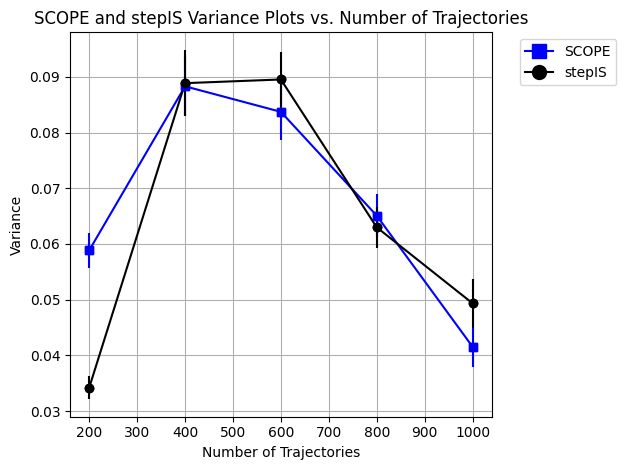

<Figure size 640x480 with 0 Axes>

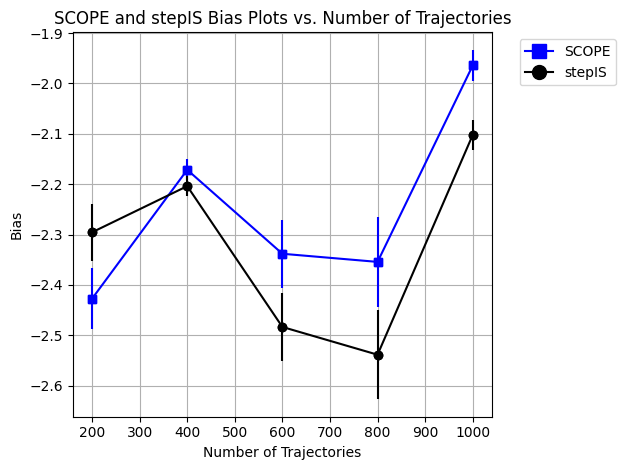

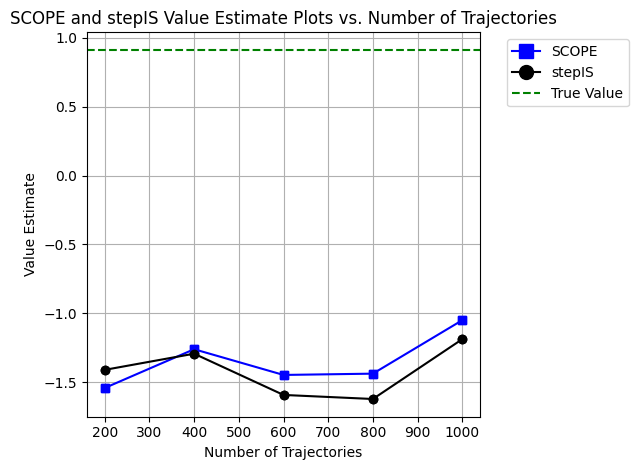

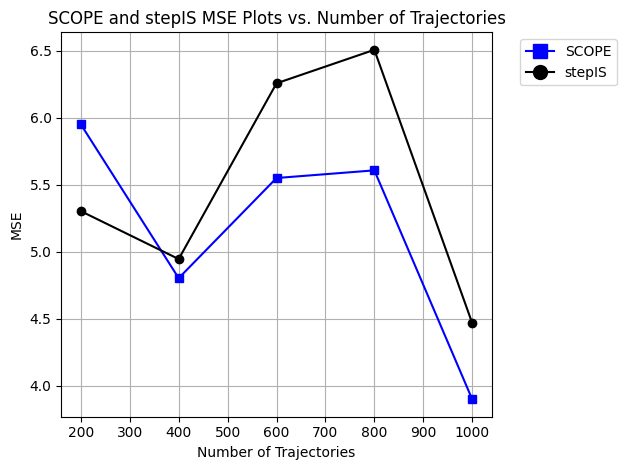

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), -1), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 1)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0)

## Sparse 2 bad, 1 good, sparse environment

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.7014289866585495, 1.74188694155637, 1.7454623309637156, 1.7685666571961451, 1.7449556619113191]
Optimal Beta:  [ 0.00944106  0.09540296 -0.08751062]
SCOPE Results:  {'std_devs_list': [0.1309776731986292, 0.13398106959718667, 0.13146760884981623, 0.13416697721896265, 0.12546145802505523], 'mean_list': [-0.5772328618986982, -0.5707559516938618, -0.5709283225586808, -0.5866699021264008, -0.5803466539437236]}
IS Results:  {'std_devs_list': [0.1115326146050463, 0.11305284152917201, 0.11139140905566075, 0.1132497212060328, 0.10556181332501972], 'mean_list': [-0.5062157481349331, -0.5001624358401242, -0.501880110682511, -0.5118085014748562, -0.5099627431729391]}
Trajectories:  400
True Val:  [1.7065542760014696, 1.7652961041687445, 1.7194726821783732, 1.7451903645687399, 1.7038761413063466]
Optimal Beta:  [-0.1362237

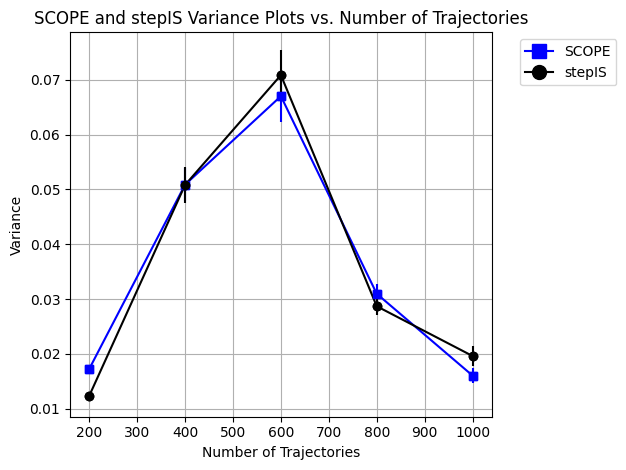

<Figure size 640x480 with 0 Axes>

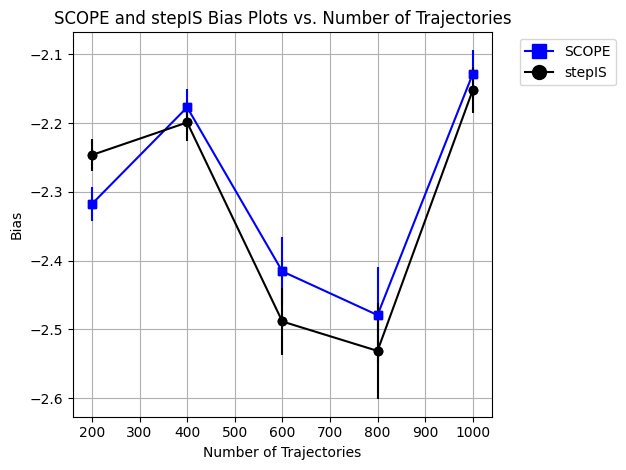

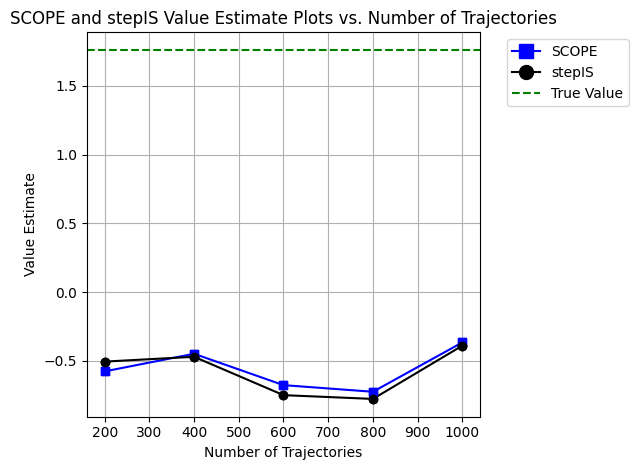

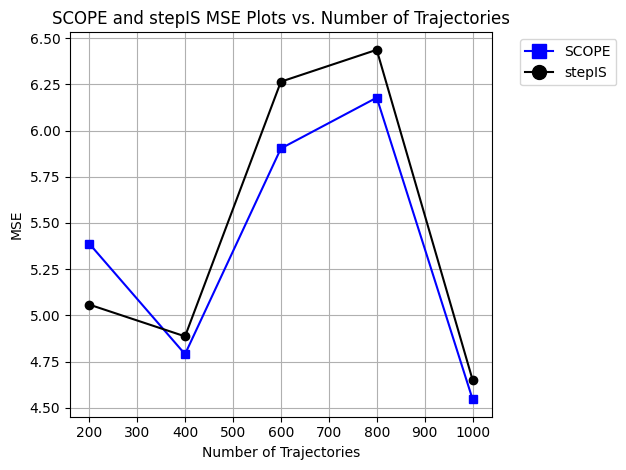

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 good, Dense 1 bad

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.11113579  0.04538095 -0.11144902]
Variance Scope: 0.07597597603140813
----------
Iteration: 2
Beta: [ 0.08523583  0.06417421 -0.10415079]
Variance Scope: 0.07282220281192717
----------
Iteration: 3
Beta: [ 0.01543842  0.09457223 -0.06766713]
Variance Scope: 0.06923770190708697
----------
Iteration: 4
Beta: [-0.00132138  0.0853235  -0.04516355]
Variance Scope: 0.06867602447068341
----------
Iteration: 5
Beta: [-0.04900889  0.03100076  0.04212679]
Variance Scope: 0.06751565355253639
----------
Iteration: 6
Beta: [-0.04847701  0.02505144  0.0465973 ]
Variance Scope: 0.06750034290438818
----------
Iteration: 7
Beta: [-0.04842727  0.0250162   0.04658258]
Variance Scope: 0.06750034075998931
----------
Var SCOPE_phi:  0.07043631573052332
Var IS_phi:  0.07009391693231173
Percent change in variance:  0.48848575339602623
SCOPE results:  {'std_devs_list': [0.15462189346294425, 0.1604437628925545, 0.16119992663123184, 0.15842773295950313, 0.16041

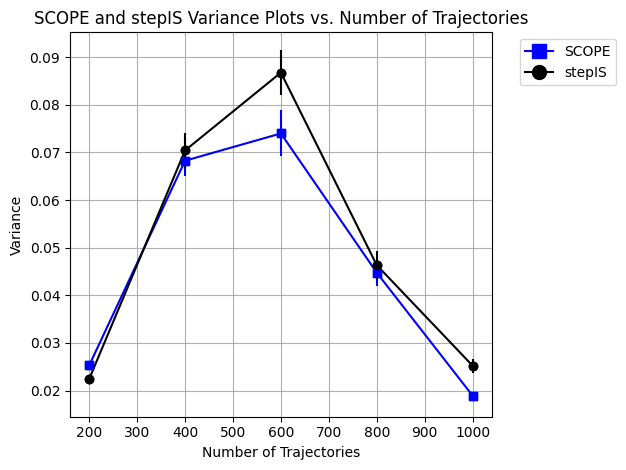

<Figure size 640x480 with 0 Axes>

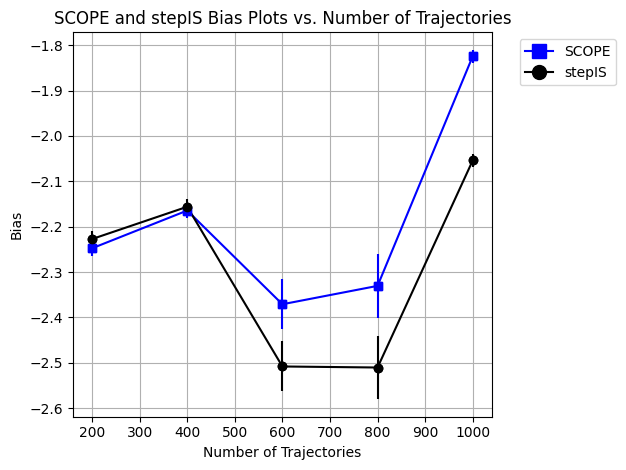

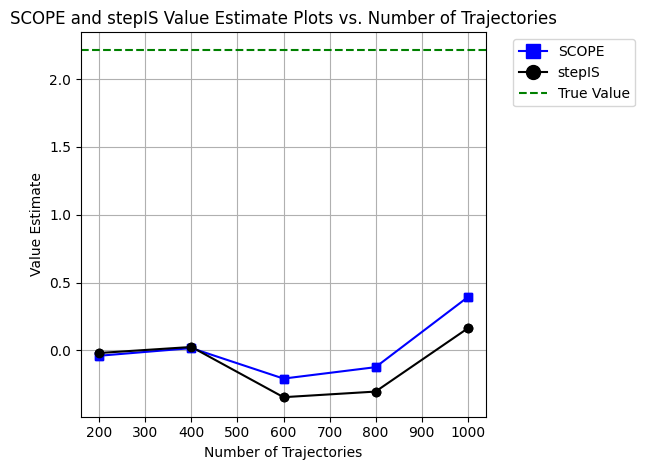

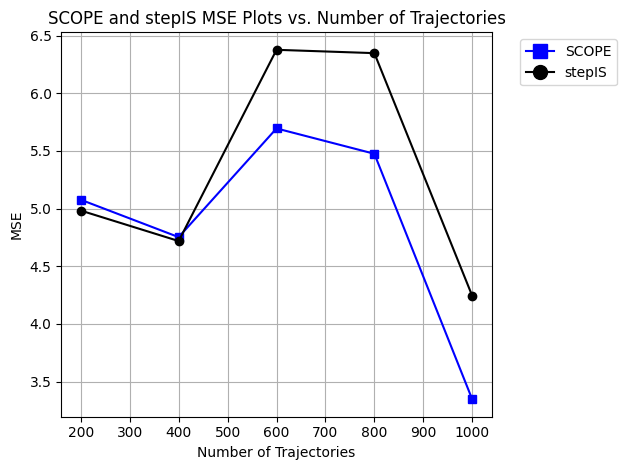

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((1, 2), 1), ((1, 1), 0)]
good_cluster_2 = [((4, 2), 1), ((4, 3), 0),((3, 2), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(31)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1)], [(2, 2),(3,3)], 1, -2, 3, 0.101)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.101)

## Sparse, 1 bad 1 good

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1)], [(3,3)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

### Same rewards for bad and good regions

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1)], [(3,3)], 2, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

## Dense 2 bad

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.9)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 2), (1, 4)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.9)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.88)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.88)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.88)

## Dense 2 bad, 0.7 for training

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.9)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.7, 0.9 )

## Sparse 2 bad, sparse environment

Trajectories:  200
True Val:  [1.4792143043983073, 1.486293146762899, 1.4993661258303739, 1.5186207838132675, 1.505253712355179]
Optimal Beta:  [-0.02894784  0.08852328]
SCOPE Results:  {'std_devs_list': [0.11236507908853344, 0.11202245761162632, 0.11042778105260768, 0.11300065766387075, 0.11169370591536174], 'mean_list': [-0.7443436037775896, -0.7476393140034292, -0.7369571734244852, -0.7525969406687536, -0.7459316417396763]}
IS Results:  {'std_devs_list': [0.12445102330014521, 0.12504736563619376, 0.12394758844469049, 0.1275509586662061, 0.12599664319831777], 'mean_list': [-0.8630475055770057, -0.8645433851131292, -0.8558262730058, -0.8737089939238337, -0.8654687284446239]}
Trajectories:  400
True Val:  [1.4699484333492967, 1.4902310146979276, 1.4767080054801642, 1.55669797035708, 1.5230995224409714]
Optimal Beta:  [-0.06448318  0.04746362]
SCOPE Results:  {'std_devs_list': [0.0624306014632603, 0.06095231973433531, 0.062444996907401455, 0.0630362609472048, 0.06402709767965656], 'mean

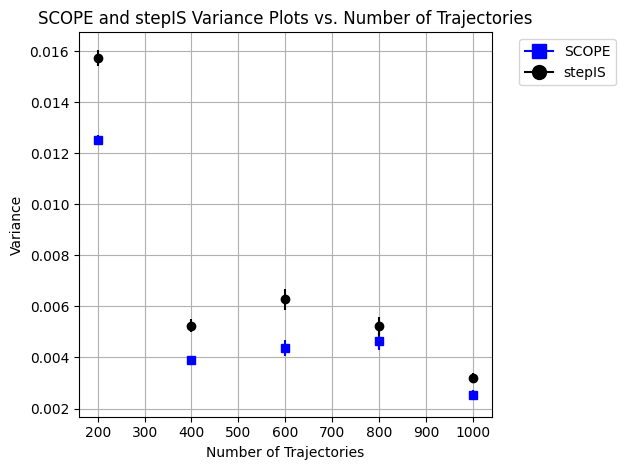

<Figure size 640x480 with 0 Axes>

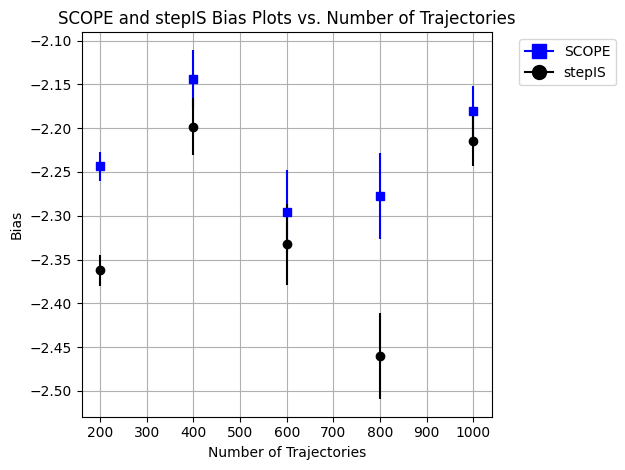

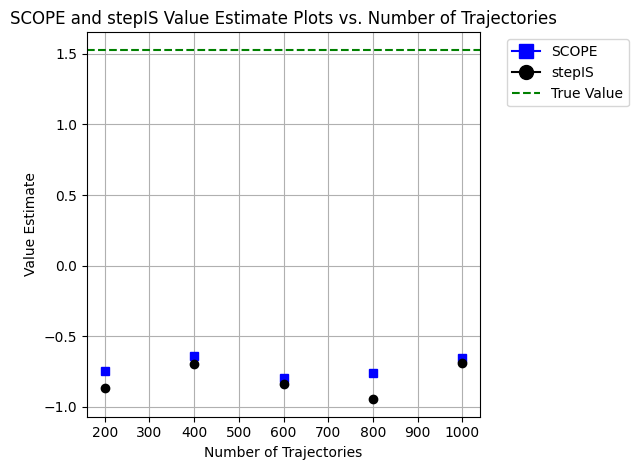

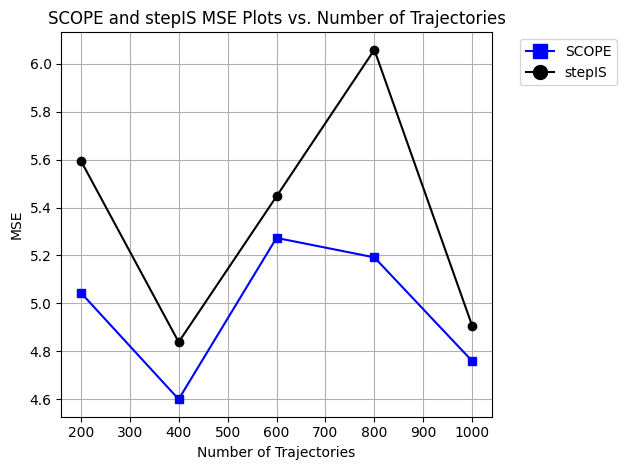

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Iteration: 1
Beta: [-0.11469592  0.14352597]
Variance Scope: 0.024901747053718185
----------
Iteration: 2
Beta: [-0.1326909   0.15399294]
Variance Scope: 0.024751623951615412
----------
Iteration: 3
Beta: [-0.12881286  0.15173718]
Variance Scope: 0.024739370063018948
----------
Var SCOPE_phi:  0.019079174965008952
Var IS_phi:  0.053430362270137866
Percent change in variance:  -64.29151112892178
SCOPE results:  {'std_devs_list': [0.09231230492497335, 0.10017744066475016, 0.09348634894709475, 0.097867829506128, 0.0941106298398535], 'mean_list': [-0.474431892097997, -0.4791335874250665, -0.4774171101082866, -0.481694574235083, -0.47703032042427496]}
IS results:  {'std_devs_list': [0.127132365304111, 0.1335468041260484, 0.12561326709267828, 0.13590020954484935, 0.1295614226856998], 'mean_list': [-0.6325989173670228, -0.6319315863608399, -0.6333848712082881, -0.645926349481126, -0.6356264969681413]}
true eval:  1.6917838890071881
Iteration: 1
Beta: [-0.26462324  0.24281691]
Variance Scope: 

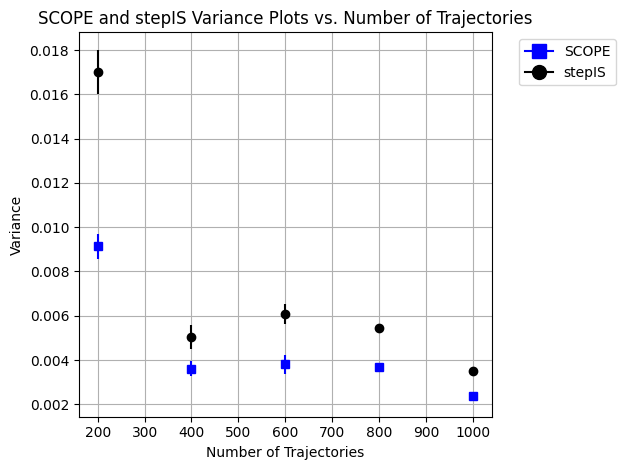

<Figure size 640x480 with 0 Axes>

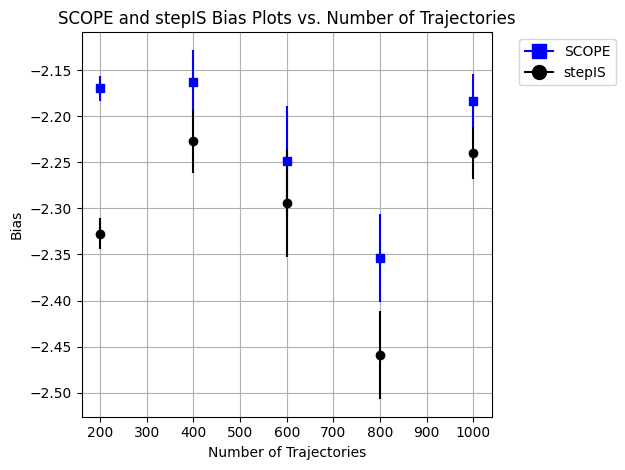

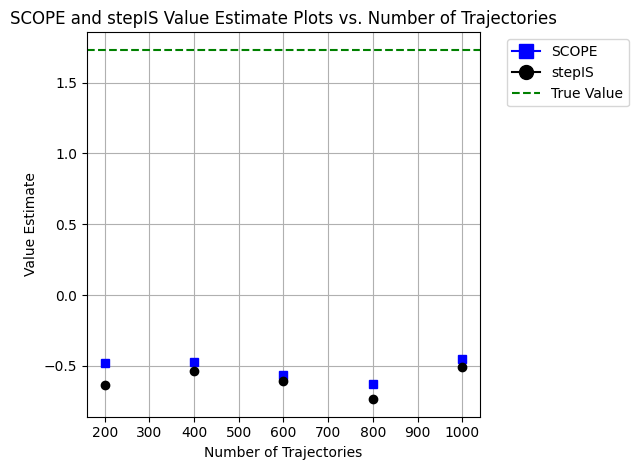

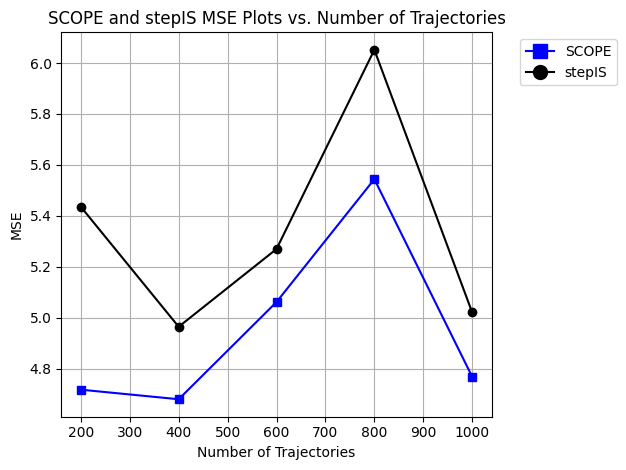

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1),((3, 4), 0)]
bad_cluster_2 = [((1, 2), -1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.01937116 -0.06199172]
Variance Scope: 0.02598535795395447
----------
Iteration: 2
Beta: [-0.02012859 -0.06029013]
Variance Scope: 0.025982803052258262
----------
Iteration: 3
Beta: [-0.02200596 -0.05607261]
Variance Scope: 0.025980168311865143
----------
Var SCOPE_phi:  0.02794199941395364
Var IS_phi:  0.028959766699359513
Percent change in variance:  -3.514418109688643
SCOPE results:  {'std_devs_list': [0.09120759723216895, 0.09446679775149605, 0.08939010277579601, 0.0951034623046326, 0.0931259016062251], 'mean_list': [-0.478947163157369, -0.4776125194926008, -0.4821880618585861, -0.4846736906971311, -0.4810641668715226]}
IS results:  {'std_devs_list': [0.1057736367056811, 0.10458290992181088, 0.1067762233626578, 0.10394347066842528, 0.10793424431068951], 'mean_list': [-0.43893629266901063, -0.43775468681942553, -0.43318345248045437, -0.44262199392754936, -0.4374081962674323]}
true eval:  1.8212892496268076
Loading  400  trajectories

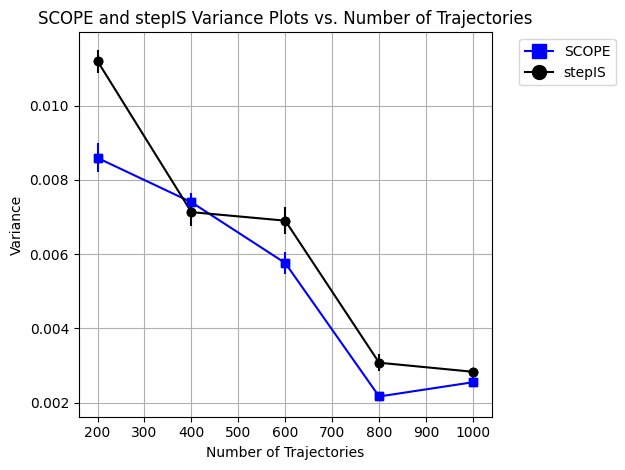

<Figure size 640x480 with 0 Axes>

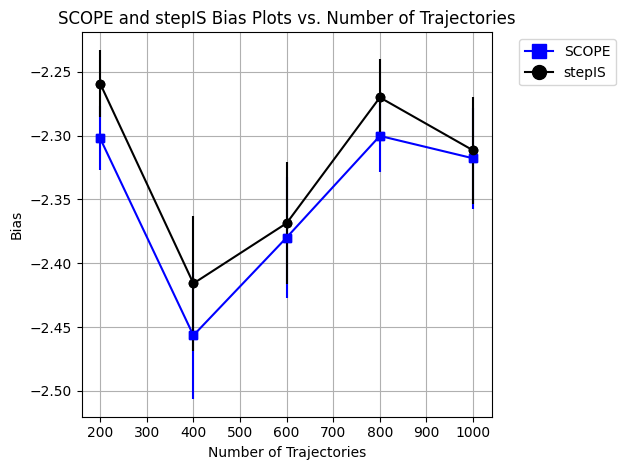

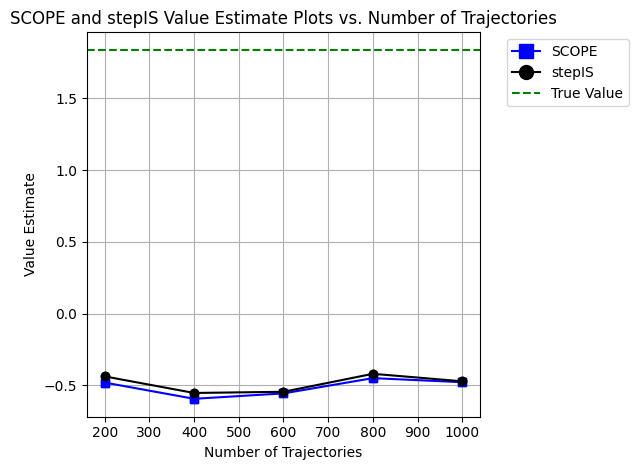

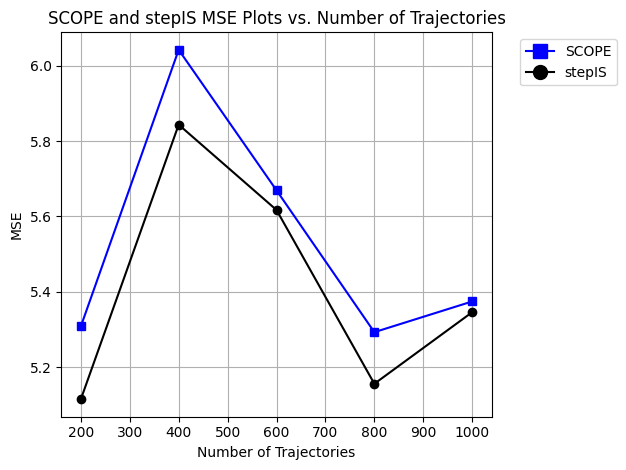

In [ ]:
#Seeds removed from SCOPE and IS

np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 2), 0), ((2, 3), -1), ((2, 4), 0)]
bad_cluster_2 = [((3, 1), -1), ((4, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (3, 2)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 2), (2, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 2), (3, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 3 bad

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 1), (2, 2), (2,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2), (3,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

### Mid Sparsity

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2), (3,3)], [], 1, -2, 3, 0.5)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.5)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.5)

## Sparse 2 good

Iteration: 1
Beta: [ 0.42250844 -0.23565305]
Variance Scope: 0.0833166910071306
----------
Iteration: 2
Beta: [ 0.13680178 -0.13583983]
Variance Scope: 0.02489141080689719
----------
Iteration: 3
Beta: [ 0.12990808 -0.14806998]
Variance Scope: 0.024746226390303397
----------
Iteration: 4
Beta: [ 0.12881229 -0.15173681]
Variance Scope: 0.024739370063294908
----------
Var SCOPE_phi:  0.019079200731139986
Var IS_phi:  0.053430362270137866
Percent change in variance:  -64.29146290515924
SCOPE results:  {'std_devs_list': [0.09231238702464627, 0.10017752418084755, 0.09348640900172092, 0.09786790950379307, 0.0941107056070091], 'mean_list': [0.4744322304051665, 0.47913390207028145, 0.47741742993103026, 0.4816949309526929, 0.47703065378060017]}
IS results:  {'std_devs_list': [0.127132365304111, 0.1335468041260484, 0.12561326709267828, 0.13590020954484935, 0.1295614226856998], 'mean_list': [0.6325989173670228, 0.6319315863608399, 0.6333848712082881, 0.645926349481126, 0.6356264969681413]}
true e

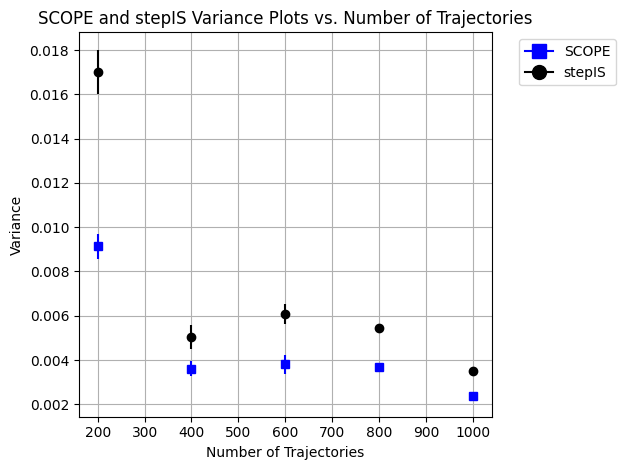

<Figure size 640x480 with 0 Axes>

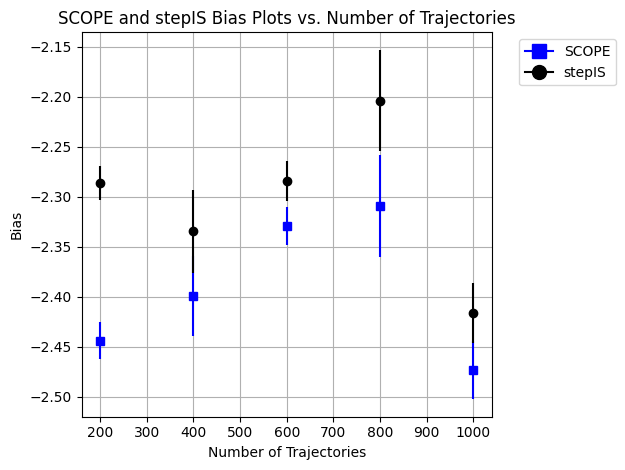

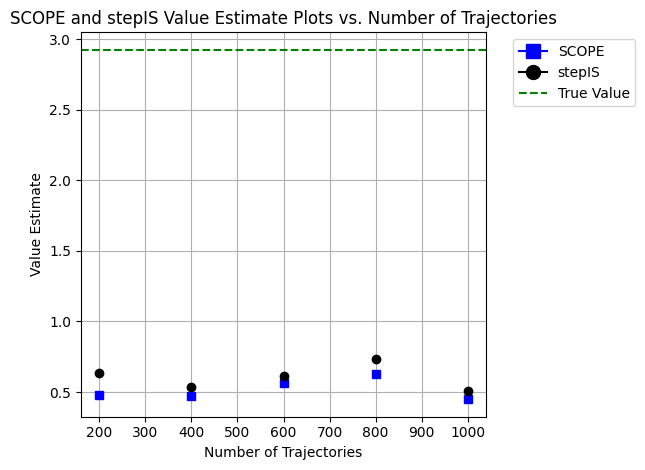

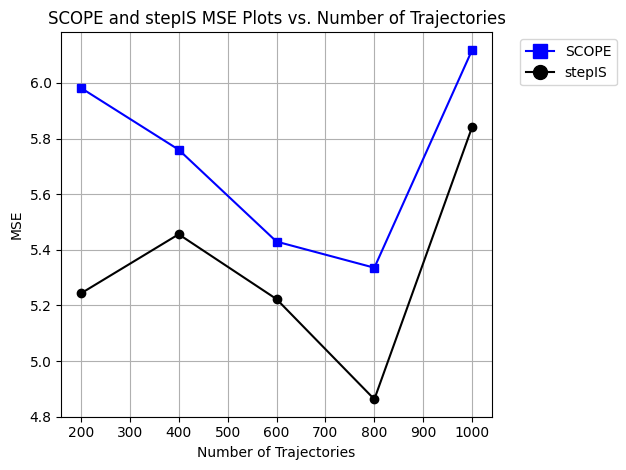

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), 1),((3, 4), 0)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Iteration: 1
Beta: [ 0.08368443 -0.08747809]
Variance Scope: 0.017151478901725914
----------
Iteration: 2
Beta: [ 0.10973149 -0.12249592]
Variance Scope: 0.015888792692682792
----------
Iteration: 3
Beta: [ 0.11907321 -0.13505499]
Variance Scope: 0.015794215443217158
----------
Var SCOPE_phi:  0.01688110852668693
Var IS_phi:  0.032075632959268074
Percent change in variance:  -47.37092624758562
SCOPE results:  {'std_devs_list': [0.14798001639342548, 0.13525055646038825, 0.1414583259933264, 0.14693969692607012, 0.140781374397116], 'mean_list': [0.4919518347600689, 0.46431813516687964, 0.4735004671128651, 0.48240127218819284, 0.4735445574674954]}
IS results:  {'std_devs_list': [0.1639656127899495, 0.14864747608575374, 0.15484830137268987, 0.164760368899075, 0.15567221349950866], 'mean_list': [0.6145178670108189, 0.5823211369263206, 0.593692763257189, 0.6092648061249375, 0.5958324040905657]}
true eval:  3.017587408585169
Iteration: 1
Beta: [ 0.02463816 -0.00834007]
Variance Scope: 0.015639

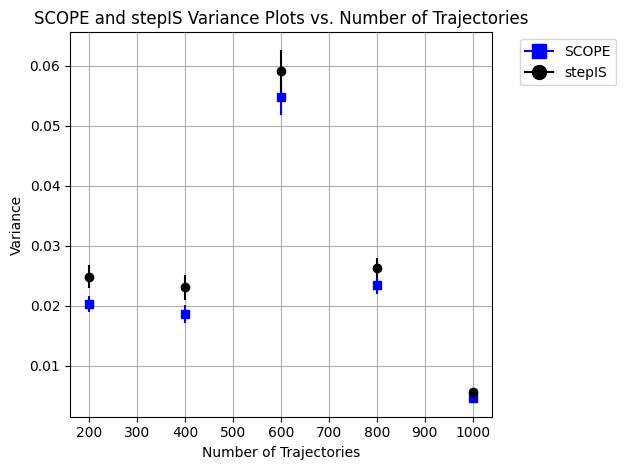

<Figure size 640x480 with 0 Axes>

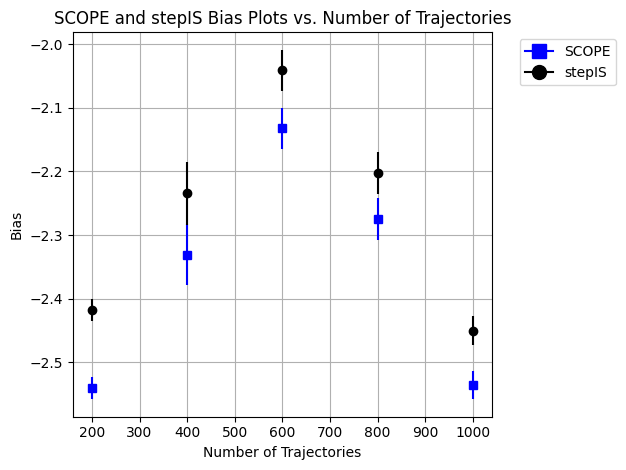

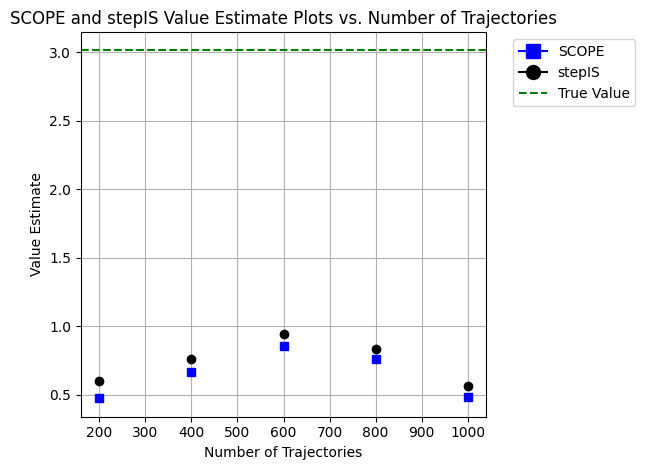

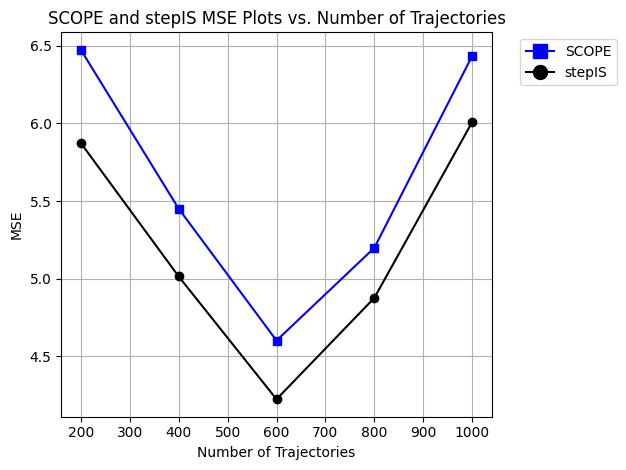

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1),((3, 4), 0)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [], [(1, 1), (2, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 1 good

Iteration: 1
Beta: [0.0107181]
Variance Scope: 0.0022783122910297222
----------
Var SCOPE_phi:  0.0032139473993054836
Var IS_phi:  0.003315138297938749
Percent change in variance:  -3.052388453784343
SCOPE results:  {'std_devs_list': [0.0655328636917547, 0.0652608288567192, 0.06725241646984965, 0.06491627903648177, 0.06414785763174054], 'mean_list': [0.20182366222364947, 0.19779891147222634, 0.2026105623475562, 0.20204985141673307, 0.20363917112411917]}
IS results:  {'std_devs_list': [0.06689576577554227, 0.06671688247133338, 0.06867333289321577, 0.06625832565330166, 0.06570014173846077], 'mean_list': [0.1965314965357002, 0.19243503932326453, 0.19712236609946007, 0.1970762398453695, 0.19830906709672522]}
true eval:  2.6380252058496856
Iteration: 1
Beta: [0.02799823]
Variance Scope: 0.009795785877037626
----------
Var SCOPE_phi:  0.009619687339302047
Var IS_phi:  0.010584746700727017
Percent change in variance:  -9.117453527335567
SCOPE results:  {'std_devs_list': [0.12935245179302735, 

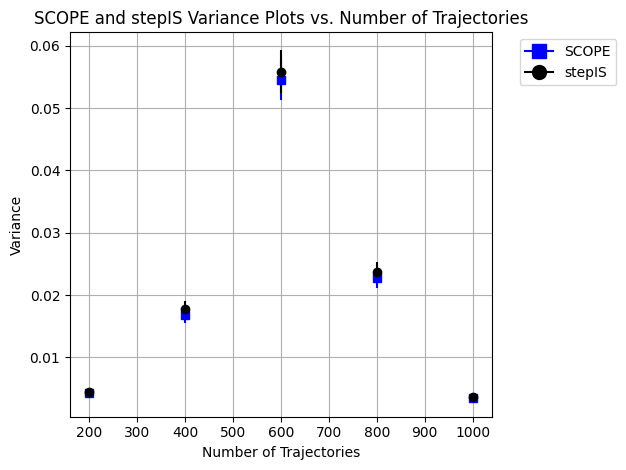

<Figure size 640x480 with 0 Axes>

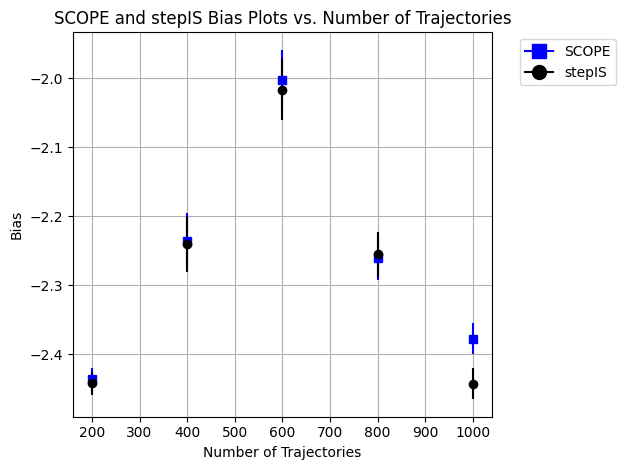

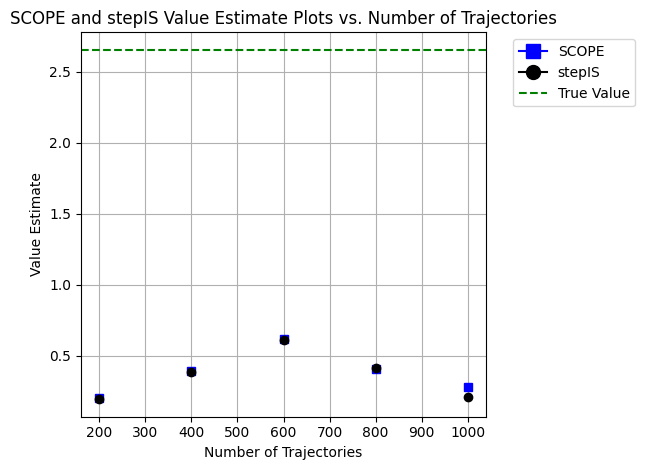

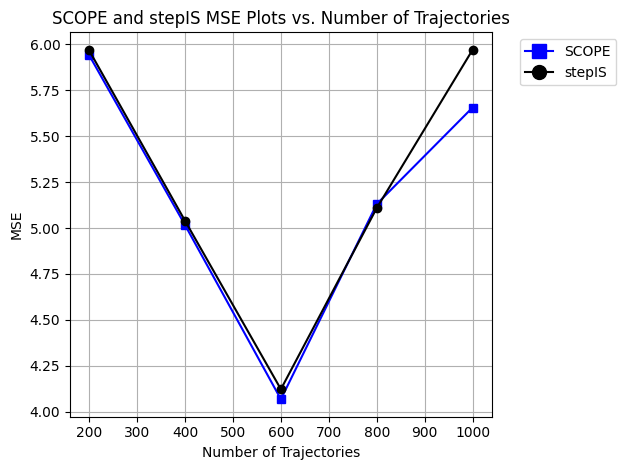

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1),((3, 4), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse, 1 bad

Iteration: 1
Beta: [-0.013176]
Variance Scope: 0.0056555332618628005
----------
Var SCOPE_phi:  0.005091661626811255
Var IS_phi:  0.0052955929414939176
Percent change in variance:  -3.850962808805554
SCOPE results:  {'std_devs_list': [0.05583943247863743, 0.05803518155361011, 0.05219338271477951, 0.05757138909585672, 0.0555034507171405], 'mean_list': [-0.181518219334573, -0.1871838674629128, -0.181266379918142, -0.1855853210886261, -0.1792219449924077]}
IS results:  {'std_devs_list': [0.057916559215373496, 0.06040543702189294, 0.0542106938261175, 0.059757577753160596, 0.05767759293314599], 'mean_list': [-0.17599773254142367, -0.18159074047150017, -0.17550922539728914, -0.18051262980527152, -0.1736364517636844]}
true eval:  2.0713460917426754
Iteration: 1
Beta: [-0.01318304]
Variance Scope: 0.0023225678061294147
----------
Var SCOPE_phi:  0.0022325603821019896
Var IS_phi:  0.0022844591532862005
Percent change in variance:  -2.271818741409951
SCOPE results:  {'std_devs_list': [0.04657415

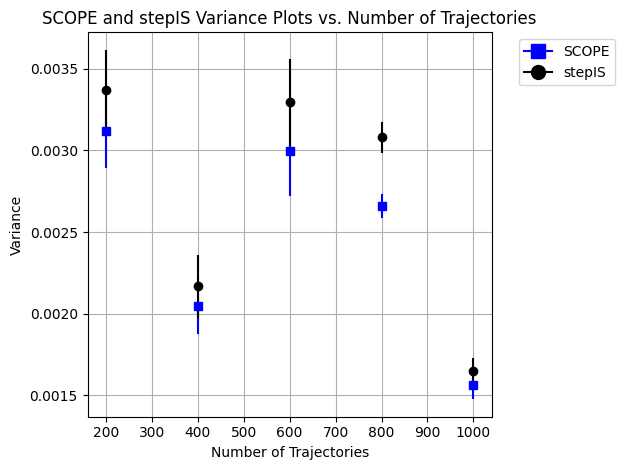

<Figure size 640x480 with 0 Axes>

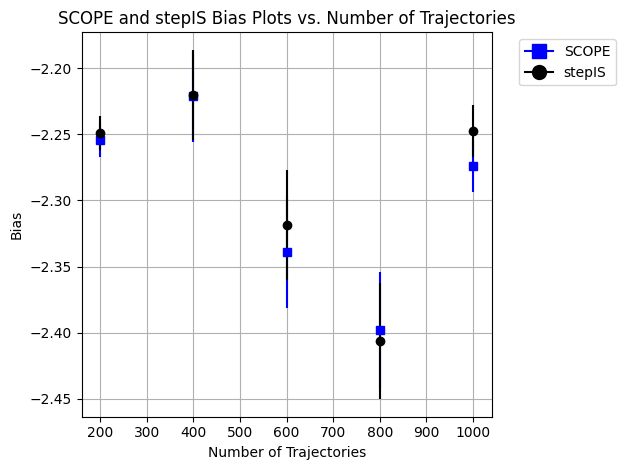

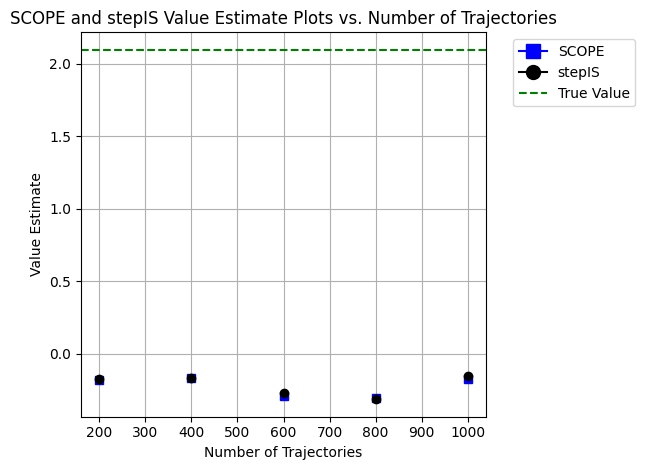

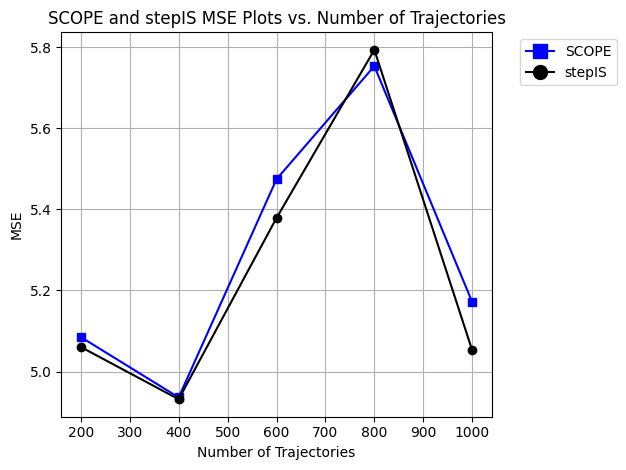

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_1 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000, 2000,10000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Loading  2000  trajectories: 
Loading  10000  trajectories: 
Iteration: 1
Beta: [-0.00220376]
Variance Scope: 0.00020990964745813378
----------


Loading  200  trajectories: 
Iteration: 1
Beta: [-0.01390415]
Variance Scope: 0.007282052147723729
----------
Var SCOPE_phi:  0.007160277628937079
Var IS_phi:  0.007244577400065566
Percent change in variance:  -1.1636257917228408
SCOPE results:  {'std_devs_list': [0.08144046255542685, 0.08586473154096237, 0.08080717779744435, 0.08197690147571157, 0.08122336252804586], 'mean_list': [-0.5370519604706986, -0.5344627624564137, -0.5340417125196926, -0.5397332123418719, -0.5379518074594674]}
IS results:  {'std_devs_list': [0.08013940645089401, 0.08473894972162821, 0.08203272520406402, 0.08338343285748939, 0.07757270941677216], 'mean_list': [-0.5203130723585044, -0.5211308829463485, -0.5218958231219533, -0.5193031454102968, -0.5226659808855623]}
true eval:  1.7494586058074675
Loading  400  trajectories: 
Iteration: 1
Beta: [0.03086389]
Variance Scope: 0.007809943726405842
----------
Var SCOPE_phi:  0.006547611080636646
Var IS_phi:  0.007152311635674036
Percent change in variance:  -8.45461699

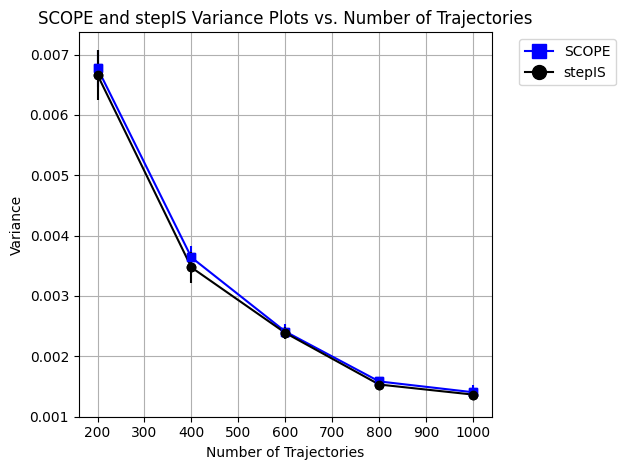

<Figure size 640x480 with 0 Axes>

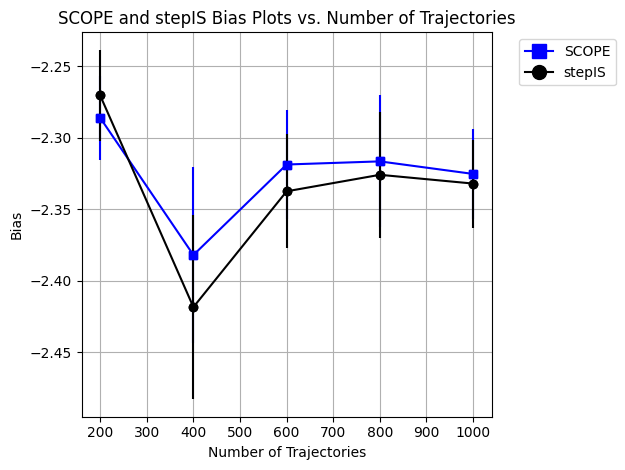

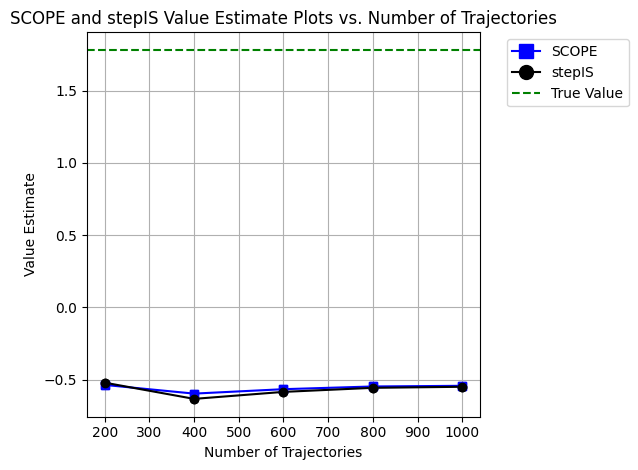

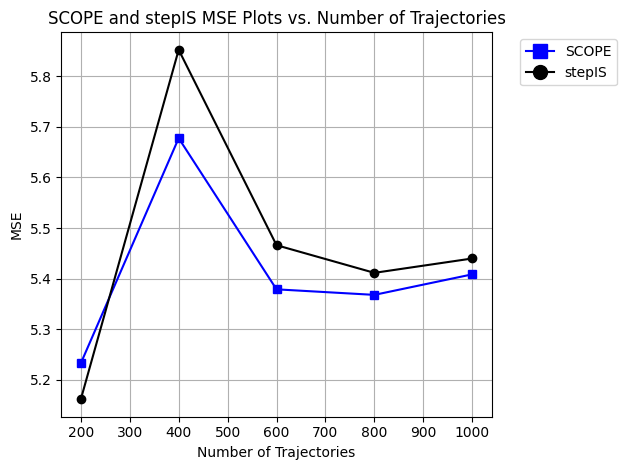

In [ ]:
# Scope and IS seeds removed
np.random.seed(42)
# Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_1 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.001)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.001)

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(3, 4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(3, 1)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(4, 2)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad, similar

In [ ]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.8)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

In [ ]:
env = GridWorld(height, width, start, end, [(4, 2)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.8)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

## Sparse, 1 bad, similar

In [ ]:
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.01)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.01)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.01 )

# Fix

## Dense same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.85)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.85 )

## Sparse same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 bad regions, same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
# num_trajectories = [200,400, 600, 800,1000]
num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse one bad region, very similar policies

In [ ]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.26, "down": 0.24, "left": 0.24, "right": 0.26}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Two bad regions

In [ ]:
env_bad = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]

In [ ]:
results = run_experiment(env_bad,200 ,behav_policy, eval_policy, 0.3)

In [ ]:
for i in num_trajectories:
  run_experiment(env_bad,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_bad, num_trajectories, behav_policy, eval_policy, 0.3)

## Single bad region

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
env_bad_one = GridWorld(height, width, start, end, [(2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
for i in num_trajectories:
  run_experiment(env_bad_one,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_bad_one, num_trajectories ,behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_bad_one, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

## Two bad regions One good region

In [ ]:
env_2bad_1good = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
run_experiment(env_2bad_1good,200, behav_policy, eval_policy, 0.3)

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good, num_trajectories, behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_2bad_1good, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

## Two bad regions One good region similar policies

In [ ]:
env_2bad_1good_similar = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
behav_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good_similar,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good_similar, num_trajectories, behav_policy, eval_policy, 0.3)